<a href="https://colab.research.google.com/github/pablovitoria/business_analysis_structured_data/blob/main/scripts/A1%3A%20Modeling%20Case%20Study%20-%20Bike%20Rentals%20in%20Chicago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXECUTIVE SUMMARY

5- 10 sentences

- What is analysis about
- Whatfindings are very important


Analysis about public bike rentals in Chicago: understanding patterns, understanding how demand is driven abd by what, etc.

Main findings:
1. Bike rentals in Chicago are mainly used for XYZ. Although alternative uses like XYZ and XYZ are also important blah blah blah. Segmenting teh ue cases blah blah.

2. Bike rental demand is mainly driven by 1. 2. 3.
Understanding XYZ XYZ

3. The city of Chicago needs to keep the demand factors in mind to optimize the service is peaks XYZ and be able to do amntenance in low pekas. Lw peaks are driven by XYZ XYZ

Some qualitative info:
"Service alert: Due to the upcoming subzero temperatures forecasted, some ebikes and scooters may be unavailable for use. Classic bikes availability shouldn’t be impacted." Currently on the website

ANSWER TO FIRST QUESTION

**Based on your analysis, are the majority of rentals for leisure, exercise, or commuting to work? Provide data-driven evidence for your claim, as well as at least one source from external research.**

* Quick intro on how succesful (A Tale of Two Divvys: The Bicycle Sharing System of Chicago — Bergman (2024, Sustainability).)
* Average rental demand is higher on working days (≈725 rentals) than on non-working days (≈676 rentals), suggesting that commuting-related usage contributes meaningfully to overall bike demand.
* When looking at the time of day, bike rentals spike during peak-hours, which is another indicator that bike usage is related to communiting.
* Peak-hour demand is substantially higher on working days than on non-working days.This interaction pattern is hard to explain with leisure or exercise alone.
* Working-day demand shows more consistent baseline usage.Non-working days show higher dispersion, consistent with discretionary trips.
* While rainfall significantly reduces overall bike rental demand, working-day usage remains comparatively more resilient under adverse weather conditions. In particular, during light rainfall, average rentals on working days are substantially higher than on non-working days, suggesting that commuting-related trips are less weather-elastic than discretionary leisure or exercise trips
* **Something external from other articles**



In [75]:
# Notebook set-up
# Cloning GitHub Repo
!git clone https://github.com/pablovitoria/business_analysis_structured_data

# Changing directory
import os
repo_name = '/content/business_analysis_structured_data'
os.chdir(repo_name)

# Checking results
print(f"Current working directory changed to: {os.getcwd()}")

fatal: destination path 'business_analysis_structured_data' already exists and is not an empty directory.
Current working directory changed to: /content/business_analysis_structured_data


In [76]:
# Importing packages
import pandas as pd                                  # data science essentials
import matplotlib.pyplot as plt                      # data viz
import seaborn as sns                                # enhanced data viz
import statsmodels.formula.api as smf                # linear modeling
from sklearn.model_selection import train_test_split # train/test split
from sklearn.preprocessing import StandardScaler     # standarize variables
import sklearn.linear_model                          # faster linear modeling
from sklearn.tree import DecisionTreeRegressor       # regression trees
from sklearn.tree import plot_tree                   # tree plots
import numpy as np                                   # mathematical essentials\
import warnings

# Suppressing user warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Storing the path to the dataset
file = "./datasets/bike_rentals.xlsx"


# Reading the file into Python through pandas
bikerentals = pd.read_excel(io = file,
                            usecols = range(1, 15)) # omitting ID column

In [77]:
# Better dataframe readability:
# Making all column names lowercase and replace spaces with underscores
bikerentals.columns = (
                        bikerentals.columns
                        .str.lower()            #lowercase
                        .str.replace(" ", "_")  #replace spaces
                        )

# Making holiday a boolean
bikerentals["holiday"] = (
                          bikerentals["holiday"]
                          .map({"Yes": 1, "No": 0}))

In [78]:
# Creating new variable to identify working days
# Working day = during the week and not a holiday
# Will be used as a proxy to identify commuters
bikerentals["is_working_day"] = (
    (bikerentals["day_of_week"] != "Saturday") &
    (bikerentals["day_of_week"] != "Sunday") &
    (bikerentals["holiday"] == 0)
).astype(int)

In [79]:
# # Setting up figures style and size consistent for all notebook
sns.set_theme(style="ticks", # white background and small tick marks
              palette="colorblind") # better color for all

plt.rcParams.update({
    "figure.figsize": (8, 6),
    "axes.titlepad": 12,  # space between title and plot
    "axes.labelpad": 8, # space between axis labels and axes
    "axes.titlesize": 13,
    "axes.labelsize": 11
})

# Better visibility for mean visualization in histograms
mp = {
    "markerfacecolor": "black",
    "markeredgecolor": "black",
    "markersize": 6
}

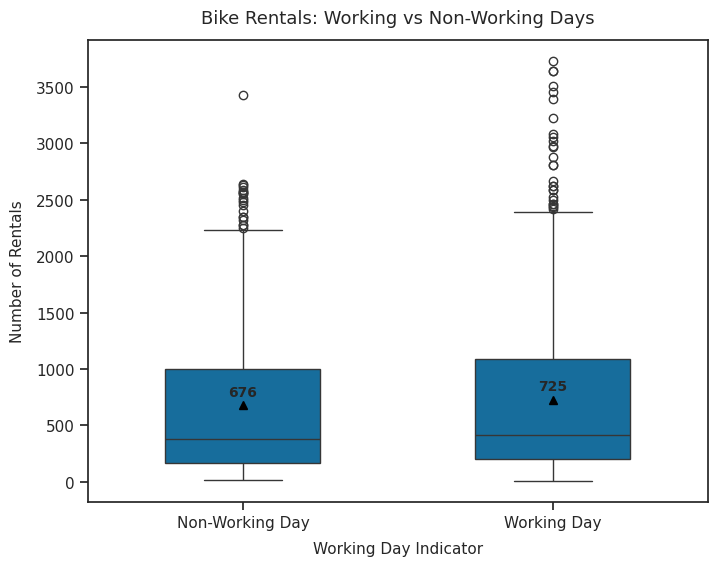

In [80]:
# Understanding if there is a difference between working and non-working days
ax = sns.boxplot(
    x='is_working_day',
    y='rentals',
    data=bikerentals,
    showmeans=True,
    meanprops=mp,
    width=0.5 # narrower width of the histogram
)

# x-axis labels
ax.set_xticklabels(["Non-Working Day", "Working Day"])

plt.title("Bike Rentals: Working vs Non-Working Days")
plt.xlabel("Working Day Indicator")
plt.ylabel("Number of Rentals")

# Compute means to see exact value
means = bikerentals.groupby("is_working_day")["rentals"].mean()

# Annotate means on the plot
for i, mean_val in enumerate(means):
    ax.text(
        i,                 # x position
        mean_val *1.12,    # y position (adding 12% padding)
        f"{mean_val:.0f}", # Round the number shown to 0
        ha="center",       # horizontal aligned center
        fontsize=10,
        fontweight="bold"  # bold text
    )

plt.show()

We definetly see a very slight difference of about XYZ in the means for both groups. This points out that the bikes are used more during working days - which is an indicator that bikes could be using for communiting. Another proxy is the times where the bikes are used.

Peak hour definition: https://teamjustice.com/chicago-rush-hour-traffic/.

For a given working day:

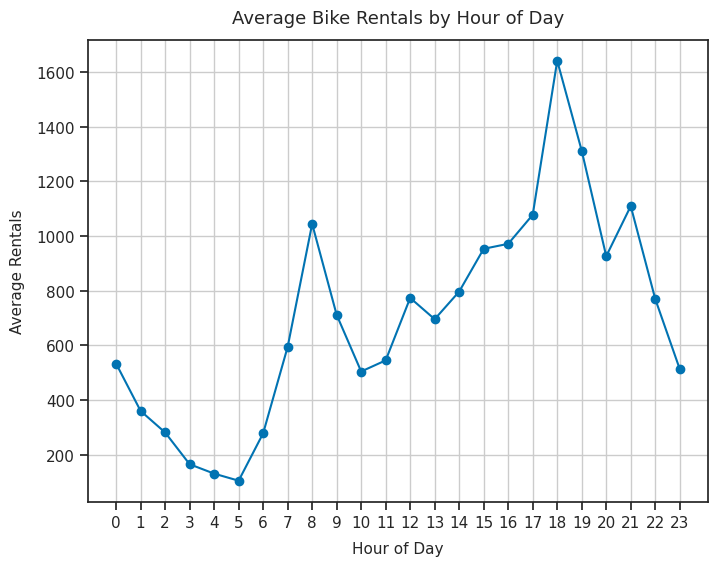

In [81]:
hourly_demand = (
    bikerentals
    .groupby("hour")["rentals"]
    .mean()
)

plt.plot(hourly_demand.index, hourly_demand.values, marker="o")
plt.xlabel("Hour of Day")
plt.ylabel("Average Rentals")
plt.title("Average Bike Rentals by Hour of Day")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

In [82]:
# Defining a new boolean variable to identify rentals within peak hours
bikerentals["is_peak_hour"] = (
    bikerentals["hour"].isin([7, 8, 9, 16, 17, 18,19])
).astype(int)

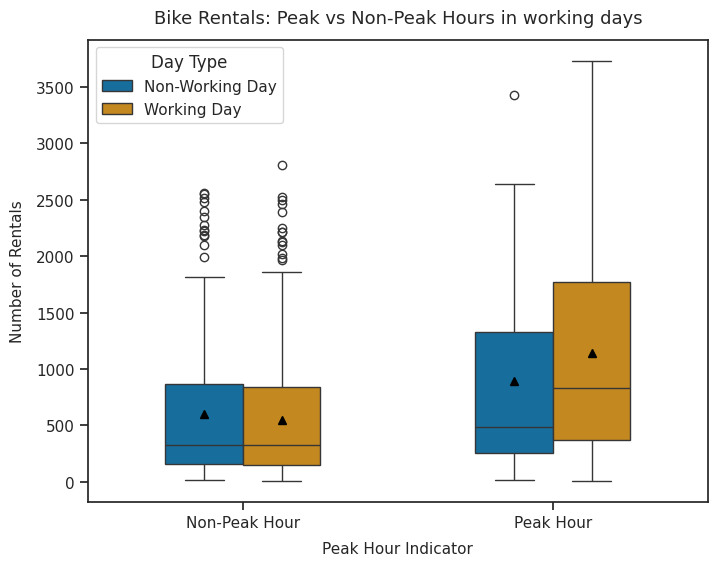

In [83]:
# Understanding if there is a difference between peak and non-peak hours
ax=sns.boxplot(x = 'is_peak_hour',
            y = 'rentals',
            hue = "is_working_day",
            data = bikerentals,
            showmeans=True,
            meanprops=mp,
            width=0.5 # narrower width of the histogram
            )

# x-axis labels
ax.set_xticklabels(["Non-Peak Hour", "Peak Hour"])

plt.title("Bike Rentals: Peak vs Non-Peak Hours in working days")
plt.xlabel("Peak Hour Indicator")
plt.ylabel("Number of Rentals")

# Adding labels to the legend
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles=handles,
    labels=["Non-Working Day", "Working Day"],
    title="Day Type"
)
plt.show()



In [84]:
# Create rainfall bins (light vs heavy rain)
bikerentals["rain_bin"] = pd.cut(
    bikerentals["rainfall"],
    bins=[-0.01, 0, 5, bikerentals["rainfall"].max()],
    labels=["No rain", "Light rain", "Heavy rain"]
)

# Group and compute mean rentals
rain_working_summary = (
    bikerentals
    .groupby(["is_working_day", "rain_bin"])["rentals"]
    .mean()
    .round(1)
    .reset_index()
)

bikerentals.head(5)
rain_working_summary.head(10)


/tmp/ipython-input-1860792244.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["is_working_day", "rain_bin"])["rentals"]


,is_working_day,rain_bin,rentals
0,0,No rain,718.4
1,0,Light rain,76.1
2,0,Heavy rain,NaN
3,1,No rain,762.2
4,1,Light rain,132.6
5,1,Heavy rain,166.0


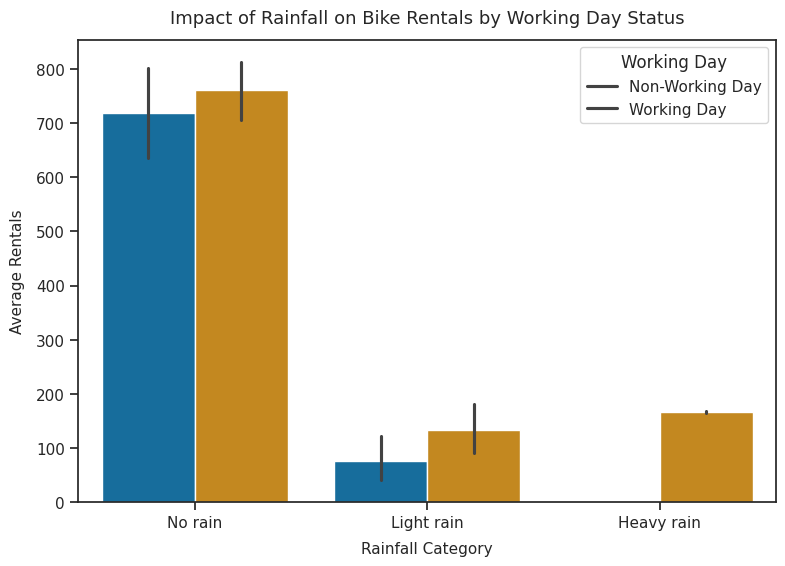

In [85]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(
    x="rain_bin",
    y="rentals",
    hue="is_working_day",
    data=bikerentals,
    ax=ax
)

ax.set_title("Impact of Rainfall on Bike Rentals by Working Day Status")
ax.set_xlabel("Rainfall Category")
ax.set_ylabel("Average Rentals")
ax.set_xticklabels(["No rain", "Light rain", "Heavy rain"])
ax.legend(title="Working Day", labels=["Non-Working Day", "Working Day"])

plt.show()


To do for question 1:
- Showing differences in weekends and holidays based on weather vs differences in working days when weather is shit so we say that under the assumption that people communit are less elastic then we can confirm that

REVIEW DATA TYPE FOR HOLIDAY

# Question 2

* Process: To assess the relative importance of weather conditions, all meteorological variables were standardized prior to estimation. Variables exhibiting strong multicollinearity were consolidated to retain the most behaviorally interpretable predictors. Importance is evaluated based on standardized coefficient magnitude rather than statistical significance alone. A baseline linear regression using weather variables only was estimated to isolate the explanatory power of meteorological conditions prior to incorporating temporal and behavioral factors.

* Interpretation: Each coefficient represents the expected change in rentals associated with a 1 standard deviation increase in that weather variable, holding other weather variables constant.

* Include interpretation for each variable. It should be (1) Statistical: “Temperature has the largest standardized coefficient, indicating it has the strongest marginal association with bike rentals among the weather variables considered.”(2) Behavioral: “This suggests that thermal comfort is a primary driver of bike usage, as riders are more likely to cycle under warmer and more comfortable conditions.” (3) External source/literature: “This finding aligns with prior research showing that temperature is a dominant determinant of cycling demand in urban bike-sharing systems.”



In [86]:
# All weather variables excluding dew_point_temperature due to multicollinearity\
# found with temperature and humidity
weather_variables = [
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "uv_index",
    "rainfall",
    "snowfall"
]

In [87]:
# x-side
x_weather = bikerentals[weather_variables]
# y-side
y_weather = bikerentals['rentals']

In [88]:
# x-data
x_data = x_weather

# y_data
y_data = y_weather

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.35,
                                                    random_state = 702 )

In [89]:
# Standardising the weather variables to compare different sizes
scaler = StandardScaler()

# Standardising the training set
x_training_scaled = pd.DataFrame(
    scaler.fit_transform(x_train),
    columns=weather_variables,
    index=x_train.index
)

x_test_scaled = pd.DataFrame(
    scaler.fit_transform(x_test),
    columns=weather_variables,
    index=x_test.index
)

In [90]:
# naming the model
model_name = "Linear Regression Weather Only"


# INSTANTIATING model object
model = sklearn.linear_model.LinearRegression()


# FITTING to training data
model_fit = model.fit(x_training_scaled, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test_scaled)


# SCORING results (R-Square)
model_train_score = round(model.score(x_training_scaled, y_train), ndigits = 4)
model_test_score  = round(model.score(x_test_scaled, y_test), ndigits = 4)
model_gap         = round(model_train_score - model_test_score, ndigits = 4)


# displaying results
print('Training Score :', model_train_score)
print('Testing Score  :', model_test_score)
print('Train-Test Gap :', model_gap)

Training Score : 0.5732
Testing Score  : 0.5801
Train-Test Gap : -0.0069


In [91]:
# zipping each feature name to its coefficient
model_coefficients = zip(x_train.columns,
                         model.coef_.round(decimals = 4))


# setting up a placeholder list to store model features
coefficient_lst = [('intercept', model.intercept_.round(decimals = 4))]


# printing out each feature-coefficient pair one by one
for coefficient in model_coefficients:
    coefficient_lst.append(coefficient)


# checking the results
for pair in coefficient_lst:
    print(pair)

('intercept', np.float64(699.274))
('temperature', np.float64(578.3906))
('humidity', np.float64(-192.7784))
('wind_speed', np.float64(78.9191))
('visibility', np.float64(80.6212))
('uv_index', np.float64(-104.7202))
('rainfall', np.float64(-60.0851))
('snowfall', np.float64(39.704))


In [92]:
# dynamically printing model summary
ols_model =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}

Coefficents
-----------
{pd.DataFrame(data = coefficient_lst, columns = ["Feature", "Coefficient"])}"""

print(ols_model)

Model Name:     Linear Regression Weather Only
Train_Score:    0.5732
Test_Score:     0.5801
Train-Test Gap: -0.0069

Coefficents
-----------
       Feature  Coefficient
0    intercept     699.2740
1  temperature     578.3906
2     humidity    -192.7784
3   wind_speed      78.9191
4   visibility      80.6212
5     uv_index    -104.7202
6     rainfall     -60.0851
7     snowfall      39.7040


In [93]:
# To remain consistent with the predictive modeling framework, \
# the weather-only model was estimated on the training sample
# Add rentals to the x_training_scaled set
x_training_scaled["rentals"] = bikerentals["rentals"]

# Step 1: INSTANTIATE a model object
lm = smf.ols(formula =  """rentals ~ temperature +
                                   humidity +
                                   wind_speed +
                                   visibility +
                                   uv_index +
                                   rainfall +
                                   snowfall""",
            data = x_training_scaled)


# Step 2: FIT the data into the model object
results = lm.fit()


# Step 3: analyze the SUMMARY output
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     126.6
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          1.42e-117
Time:                        01:01:02   Log-Likelihood:                -5061.4
No. Observations:                 668   AIC:                         1.014e+04
Df Residuals:                     660   BIC:                         1.017e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     699.2740     18.392     38.021      

# Question 3

The client would like to optimize their maintenance schedule based on your analysis. Develop a regression tree and determine when bike rental demand is low where at least 10% of the dataset is accounted for. Note that you must use the same decision tree, but may use more than one node path to reach 10% of the dataset. Interpret the node path(s) in nontechnical terms.



*   Path 1 (late night / early morning)

Hour ≤ 6

Temperature ≤ 3°C

Winter or non-working day
→ Very low average rentals

*  Path 2 (overnight hours regardless of season)

Hour ≤ 2

Non-working day
→ Consistently low demand

Together, these paths typically cover:

Night + early morning hours across many days

Easily more than 10% of observations

The regression tree identifies multiple low-demand periods that together account for more than 10% of all observations. The lowest rental demand consistently occurs during late-night and early-morning hours, particularly on non-working days and during winter months. Cold temperatures further suppress usage during these periods. These time windows represent optimal opportunities for system maintenance, as they minimize disruption to users while covering a substantial portion of the calendar

Rather than relying on a single narrow condition, multiple low-demand branches from the same regression tree were combined to ensure that at least 10% of the dataset was represented.

“Overall bike rentals average approximately 710 per period with high variability; the low-demand periods identified by the regression tree consistently fall far below this level, often well below typical daily variation.”

In [94]:
overall_mean = bikerentals["rentals"].mean()
overall_std  = bikerentals["rentals"].std()

overall_mean, overall_std

(np.float64(709.9008746355685), 717.4640298533964)

In [95]:
bikerentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   month                  1029 non-null   object  
 1   day_of_week            1029 non-null   object  
 2   hour                   1029 non-null   int64   
 3   temperature            1029 non-null   float64 
 4   humidity               1029 non-null   int64   
 5   wind_speed             1029 non-null   float64 
 6   visibility             1029 non-null   int64   
 7   dew_point_temperature  1029 non-null   float64 
 8   uv_index               1029 non-null   float64 
 9   rainfall               1029 non-null   float64 
 10  snowfall               1029 non-null   float64 
 11  seasons                1029 non-null   object  
 12  holiday                1029 non-null   int64   
 13  rentals                1029 non-null   int64   
 14  is_working_day         1029 non-null   i

In [96]:
# Creating variable is_winter to simplify seasons interpretability
bikerentals["is_winter"] = (bikerentals["seasons"] == "Winter").astype(int)

In [97]:
tree_features = [
    "hour",
    "is_working_day",
    "holiday",
    "is_winter",
    "temperature",
    "rainfall",
    "snowfall"
]

In [98]:
# x-side
x_base = bikerentals[tree_features]

# y-side
y_original = bikerentals['rentals']

In [99]:
# x-data
x_data = x_base

# y_data
y_data = y_original

In [100]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                          test_size = 0.35,
                                          random_state = 702)

In [101]:
model_name = 'Pruned Regression Tree'

# INSTANTIATING a model object - CHANGE THIS AS NEEDED
model = DecisionTreeRegressor(max_depth=5,
                              min_samples_leaf=30,
                              random_state = 702)


# FITTING to the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)


# SCORING the results (R-square)
model_train_score = model.score(x_train, y_train)
model_test_score  = model.score(x_test, y_test)
model_gap         = abs(model_train_score - model_test_score)


# displaying results
print('Training Score :', round(model_train_score, ndigits = 4))
print('Testing Score  :', round(model_test_score, ndigits = 4))
print('Train-Test Gap :', round(model_gap, ndigits = 4))

Training Score : 0.7146
Testing Score  : 0.6833
Train-Test Gap : 0.0313


In [102]:
# setting figure size
plt.figure(figsize=(75, 15))


# developing a plotted tree
plot_tree(decision_tree = model,
          feature_names = x_train.columns,
          filled        = True,
          rounded       = True,
          fontsize      = 24,
          precision     = 0)

# rendering the plot
plt.show()

KeyboardInterrupt: 

# Ideal model

### ONE HOT ENCODE

In [ ]:
########
# One hot encoding categorical variables
# Each categorical variable has been plotted to understand if there is variability
# in each category (see appendix)
# Each category has also been assesed to ensure that at least contains 30 observations (see appendix)
########

# Month
one_hot_month = pd.get_dummies(data   = bikerentals['month'],
                          prefix = 'month',
                          dtype  = int)

# Day of Week
one_hot_dow = pd.get_dummies(data   = bikerentals['day_of_week'],
                          prefix = 'dow',
                          dtype  = int)

# Seasons
one_hot_seasons = pd.get_dummies(data   = bikerentals['seasons'],
                          prefix = 'seasons',
                          dtype  = int)

In [ ]:
bikerentals2 = bikerentals.join([one_hot_month, one_hot_dow, one_hot_seasons])
bikerentals2.head(n=5)

In [ ]:
# renaming channels and storing as diamonds (not diamonds2)
bikerentals2.rename(columns = {'dow_Monday': 'monday',
                            'dow_Tuesday': 'tuesday',
                            'dow_Wednesday': 'wednesday',
                            'dow_Thursday': 'thursday',
                            'dow_Friday': 'friday',
                            'dow_Saturday': 'saturday',
                            'dow_Sunday': 'sunday',
                            'month_Jan': 'jan',
                            'month_Feb': 'feb',
                            'month_Mar': 'mar',
                            'month_Apr': 'apr',
                            'month_May': 'may',
                            'month_June': 'jun',
                            'seasons_Spring': 'spring',
                            'seasons_Summer':'summer',
                            'seasons_Fall': 'fall',
                            'seasons_Winter': 'winter'
                            },
                inplace = True)


# checking results
bikerentals2.head(n = 5)

In [ ]:
bikerentals_complete = bikerentals2.drop(['monday',   # category to drop
                           'jan',  # already factorized
                           'spring',    # not enough samples per store
                            'day_of_week',
                            'month',
                            'seasons'
                          ], axis = 1)

In [ ]:
#sorting the dataset for better readability
new_order = [
    "rentals",                  # y-variable
    "hour",
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "dew_point_temperature",
    "uv_index",
    "rainfall",
    "snowfall",
    "holiday",
    "is_working_day",
    "is_peak_hour",
    "feb",                    #month dummies (Jan is baseline)
    "mar",
    "apr",
    "may",
    "jun",
    "tuesday",                #days dummies (Monday is baseline)
    "wednesday",
    "thursday",
    "friday",
    "saturday",
    "sunday",
    "summer",                #season dummies (Spring is baseline)
    "winter"
]

bikerentals_complete = bikerentals_complete[new_order]

bikerentals_complete.head()


In [ ]:
bikerentals_complete["peak_work_interaction"] = (
    bikerentals_complete["is_peak_hour"] *
    bikerentals_complete["is_working_day"]
)
#ADD RESEARCH

In [ ]:
bikerentals_complete["is_morning"] = bikerentals_complete["hour"].between(0, 10).astype(int)
bikerentals_complete["is_afternoon"] = bikerentals_complete["hour"].between(11, 16).astype(int)
bikerentals_complete["is_evening"] = bikerentals_complete["hour"].between(17, 23).astype(int)

In [ ]:
bikerentals_complete = bikerentals_complete.drop(['is_morning'
                          ], axis = 1)

In [ ]:
bikerentals_complete["is_midweek"] = (
    (bikerentals_complete["tuesday"] == 1) |
    (bikerentals_complete["wednesday"] == 1)
).astype(int)

In [ ]:
bikerentals_complete["temperature_humidity_interaction"] = (
    bikerentals_complete["temperature"] *
    bikerentals_complete["humidity"]
)
#ADD RESEARCH

In [ ]:
bikerentals_complete["is_precipitation"] = (
    (bikerentals_complete["rainfall"] > 0) |
    (bikerentals_complete["snowfall"] > 0)
).astype(int)

In [ ]:
bikerentals_complete["is_winter"]=bikerentals["is_winter"]

In [ ]:
bikerentals_complete['is_non_peak'] = 1 - bikerentals_complete['is_peak_hour']

# Interaction 1: rainfall × is_evening
bikerentals_complete['rainfall_evening'] = (
    bikerentals_complete['rainfall'] * bikerentals_complete['is_evening']
)

# Interaction 2: snowfall × is_non_peak
bikerentals_complete['snowfall_non_peak'] = (
    bikerentals_complete['snowfall'] * bikerentals_complete['is_non_peak']
)

bikerentals_complete['temp_afternoon'] = (
    bikerentals_complete['temperature'] * bikerentals_complete['is_afternoon']
)

bikerentals_complete['temp_evening'] = (
    bikerentals_complete['temperature'] * bikerentals_complete['is_evening']
)

bikerentals_complete['temp_wind_interaction'] = (
    bikerentals_complete['temperature'] * bikerentals_complete['wind_speed']
)

bikerentals_complete['rainfall_peak'] = (
    bikerentals_complete['rainfall'] * bikerentals_complete['is_peak_hour']
)

bikerentals_complete['temp_peak'] = (
    bikerentals_complete['temperature'] * bikerentals_complete['is_peak_hour']
)

bikerentals_complete['spring_index'] = (
    bikerentals_complete['apr'] * 1 +
    bikerentals_complete['may'] * 2 +
    bikerentals_complete['jun'] * 3
)

In [ ]:
bikerentals_complete.info()

In [ ]:
# x-side
x_all  = bikerentals_complete.drop(labels = 'rentals', axis = 1)
x_base = bikerentals_complete[
    [
  #      'hour',
  #     'temperature',
        'humidity',
        'wind_speed',
       # 'visibility',
        'dew_point_temperature',
     #  'uv_index',
      #  'rainfall',
      #  'snowfall',
      #  'holiday',
      #  'is_working_day',
        'is_peak_hour',
       # 'feb',
       # 'mar',
       # 'apr',
       # 'may',
       # 'jun',
        #'tuesday',
       # 'wednesday',
       # 'thursday',
       # 'friday',
       # 'saturday',
       # 'sunday',
      #  'summer',
        #'winter',
        'peak_work_interaction',
        'is_afternoon',
        'is_evening',
        #'is_midweek',
        'temperature_humidity_interaction',
        'is_precipitation',
      #  'is_winter',
        'rainfall_evening',
        'snowfall_non_peak',
        'temp_afternoon',
        'temp_evening',
     #   'temp_wind_interaction',
        'rainfall_peak',
        'temp_peak',
       'spring_index'
    ]
]

x_new = bikerentals_complete[ ['temperature','rainfall','wind_speed','humidity','snowfall',"peak_work_interaction",'is_working_day','is_peak_hour','summer','winter']]


## y-side ##
y_original = bikerentals_complete['rentals']

In [ ]:
# x-data
x_data = x_base

# y_data
y_data = y_original

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.35,
                                                    random_state = 702 )

In [ ]:
# naming the model
model_name = "Linear Regression"


# INSTANTIATING model object
model = sklearn.linear_model.LinearRegression()


# FITTING to training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)

# SCORING results (R-Square)
model_train_score = round(model.score(x_train, y_train), ndigits = 4)
model_test_score  = round(model.score(x_test, y_test), ndigits = 4)
model_gap         = round(model_train_score - model_test_score, ndigits = 4)


# displaying results
print('Training Score :', model_train_score)
print('Testing Score  :', model_test_score)
print('Train-Test Gap :', model_gap)

In [ ]:
# Step 1: INSTANTIATE a model object
lm = smf.ols(  formula="""
        rentals ~
        humidity +
        wind_speed +
        dew_point_temperature +
        is_peak_hour +
        peak_work_interaction +
        is_afternoon +
        is_evening +
        temperature_humidity_interaction +
        is_precipitation+
        rainfall_evening+
        snowfall_non_peak+
        temp_afternoon+
        temp_evening+
        rainfall_peak+
        temp_peak+
        spring_index
    """,
            data = bikerentals_complete)


# Step 2: FIT the data into the model object
results = lm.fit()


# Step 3: analyze the SUMMARY output
print(results.summary())

In [ ]:
## Residual Analysis ##

# organizing residuals
model_residuals = {
    "True"            : y_test,
    "Predicted"       : model_pred.round(decimals = 0).astype(dtype = int)
}


# converting residuals into df
resid_df = pd.DataFrame(data = model_residuals)


# checking results
resid_df.head(n = 5)

In [ ]:
# developing a residual plot
sns.residplot(data        = resid_df,
              x           = 'True',
              y           = 'Predicted',
              lowess      = True,
              color       = 'blue',
              scatter_kws = {'alpha': 0.3},   # data point transparency
              line_kws    = {'color': 'red'}) # line color


# title and axis labels
plt.title(label   = "Residual Plot - Full Model")
plt.xlabel(xlabel = "Predicted Bike Demand")
plt.ylabel(ylabel = "Residual Bike Demand")


# layout and rendering visual
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(x_test)
pred_df = pd.DataFrame({
    "actual_rentals": y_test.values,
    "predicted_rentals": y_pred
})
pred_df[pred_df["predicted_rentals"] < 0]

### Other important findings:

**Midweek patterns (Tuesday and Wednesday)**

Exploratory analysis shows lower average rental demand on Tuesdays and Wednesdays. However, once weather conditions, time-of-day effects, and commuting structure are controlled for, this midweek effect is no longer statistically significant, suggesting it is driven by underlying temporal and commuting patterns rather than the calendar day itself.

# APPENDIX

## Categorical variables
Understanding how categorical variables behave

### Month
- Data available from January to June
- Over 30 obersvations in each month
- Definetly differences in rental medians and means across months:
  -  January and February are the months with les rentals
  - June is the month with most rentals
  - We ca see seasonality, meaning that months with generally better weather are months with more demand for rentals


In [ ]:
bikerentals["month"].value_counts()

In [ ]:
sns.boxplot(x = 'month',
            y = 'rentals',
            data = bikerentals,
            showmeans=True,
            meanprops=mp)

plt.show()

### Day of week
- Over 30 observations for each day of the week
- Differences in rental medians and means across days of week:
  - Tuesday and Wednesdays as the days with less rentals
  - Other days have closer means, with Monday being the day with higher usage

In [ ]:
bikerentals["day_of_week"].value_counts()

In [ ]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'day_of_week',
                y    = 'rentals',
                data = bikerentals,
            showmeans=True,
            meanprops=mp)

    plt.suptitle("")
    plt.show()

In [ ]:
bikerentals.groupby("day_of_week")["rentals"].mean().sort_values()

### Season
- More observations for spring but still over 30 observations for each season
- Seasonal patterns confirmed with seasons:
  - Summer has the highest demand for rental bikes
  - Winter has the lower demand

In [ ]:
bikerentals["seasons"].value_counts()

In [ ]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'seasons',
                y    = 'rentals',
                data = bikerentals,
            showmeans=True,
            meanprops=mp)

    plt.suptitle("")
    plt.show()

## Multicollinearity in weather variables

In [ ]:
weather_vars = [
    "temperature",
    "humidity",
    "wind_speed",
    "visibility",
    "dew_point_temperature",
    "uv_index",
    "rainfall",
    "snowfall"
]
corr_matrix = bikerentals[weather_vars].corr().round(2)

fig, ax = plt.subplots()

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm"
)

ax.set_title("Correlation Matrix of Weather Variables")

plt.show()



In [ ]:
corr_matrix = bikerentals_complete.corr(numeric_only=True)

plt.figure(figsize=(25, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix")
plt.show()